In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd


np.random.seed(55)
%matplotlib inline


In [3]:
#importing all the data
df_original = pd.read_csv("../input/store-sales-time-series-forecasting/train.csv",
                      parse_dates=["date"])
store_info = pd.read_csv("../input/store-sales-time-series-forecasting/stores.csv")
oil_info = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv",
                      parse_dates=["date"])
df_test = pd.read_csv("../input/store-sales-time-series-forecasting/test.csv",
                     parse_dates=["date"])



### Combine dataframes

In [4]:
df_tmp = pd.merge(df_original, store_info)
df_tmp = pd.merge(df_tmp, oil_info)
df_test = pd.merge(df_test, store_info)
df_test = pd.merge(df_test, oil_info)

In [5]:
df_eda = pd.merge(df_original, store_info)
df_eda = pd.merge(df_eda, oil_info)

### Clean up data types and fill missing data

In [6]:
#sort by date
df_tmp.sort_values(by=["date"], inplace=True, ascending=True)

In [7]:
#check for missing data
df_tmp.isna().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
city               0
state              0
type               0
cluster            0
dcoilwtico     71280
dtype: int64

In [8]:
#split date data to enrich data set + remove date column
df_tmp["saleYear"] = df_tmp.date.dt.year
df_tmp["saleMonth"] = df_tmp.date.dt.month
df_tmp["saleDay"] = df_tmp.date.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.date.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.date.dt.dayofyear

df_tmp.drop("date", axis=1, inplace=True)

df_test["saleYear"] = df_test.date.dt.year
df_test["saleMonth"] = df_test.date.dt.month
df_test["saleDay"] = df_test.date.dt.day
df_test["saleDayOfWeek"] = df_test.date.dt.dayofweek
df_test["saleDayOfYear"] = df_test.date.dt.dayofyear

df_test.drop("date", axis=1, inplace=True)

In [9]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2143746 entries, 0 to 2143745
Data columns (total 15 columns):
 #   Column         Dtype  
---  ------         -----  
 0   id             int64  
 1   store_nbr      int64  
 2   family         object 
 3   sales          float64
 4   onpromotion    int64  
 5   city           object 
 6   state          object 
 7   type           object 
 8   cluster        int64  
 9   dcoilwtico     float64
 10  saleYear       int64  
 11  saleMonth      int64  
 12  saleDay        int64  
 13  saleDayOfWeek  int64  
 14  saleDayOfYear  int64  
dtypes: float64(2), int64(9), object(4)
memory usage: 261.7+ MB


In [10]:
#fill missing data and add column to mark if data is missing
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #add a binary column to tell is was missing data
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            #fill with median
            df_tmp[label] = content.fillna(content.median())
            
for label, content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #add a binary column to tell is was missing data
            df_test[label+"_is_missing"] = pd.isnull(content)
            #fill with median
            df_test[label] = content.fillna(content.median())

In [11]:
#convert strings to categories, family, city, state, type

df_tmp["family"] = df_tmp["family"].astype('category')
df_tmp["city"] = df_tmp["city"].astype('category')
df_tmp["state"] = df_tmp["state"].astype('category')
df_tmp["type"] = df_tmp["type"].astype('category')

df_test["family"] = df_test["family"].astype('category')
df_test["city"] = df_test["city"].astype('category')
df_test["state"] = df_test["state"].astype('category')
df_test["type"] = df_test["type"].astype('category')

In [12]:
#convert categories for modeling

for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label] = pd.Categorical(content).codes+1     

In [13]:
df_tmp.tail()

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,dcoilwtico_is_missing
2142551,2999693,25,27,3.000,0,21,14,4,1,47.57,2017,8,15,1,227,False
2142550,2999692,25,26,93.000,8,21,14,4,1,47.57,2017,8,15,1,227,False
2142549,2999691,25,25,180.107,0,21,14,4,1,47.57,2017,8,15,1,227,False
2142560,2999702,26,3,0.000,0,9,7,4,10,47.57,2017,8,15,1,227,False
2143745,3000887,9,33,16.000,0,19,13,2,6,47.57,2017,8,15,1,227,False


### EDA


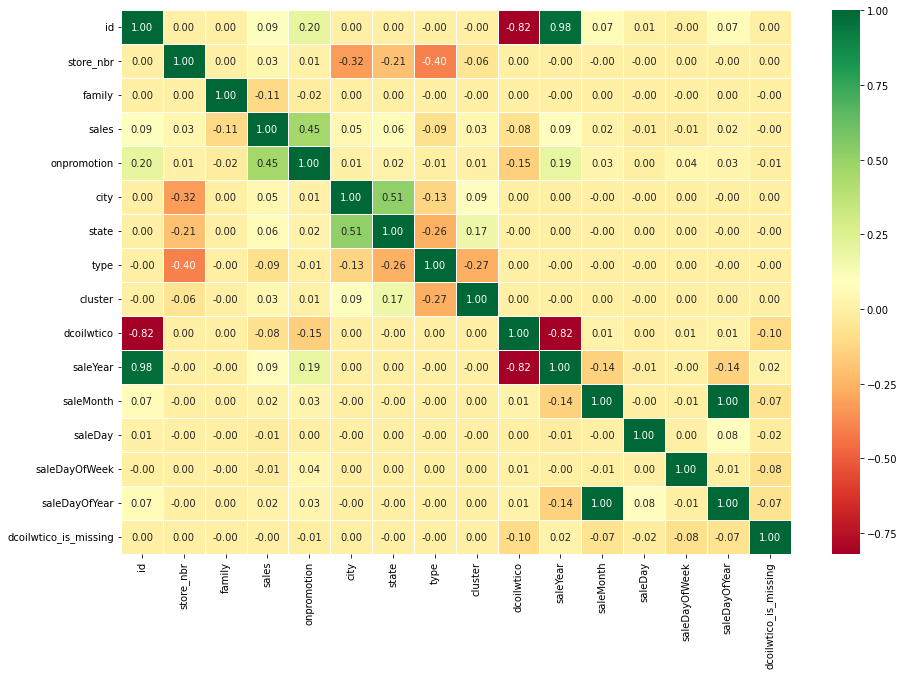

In [14]:
corr_matrix = df_tmp.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="RdYlGn");

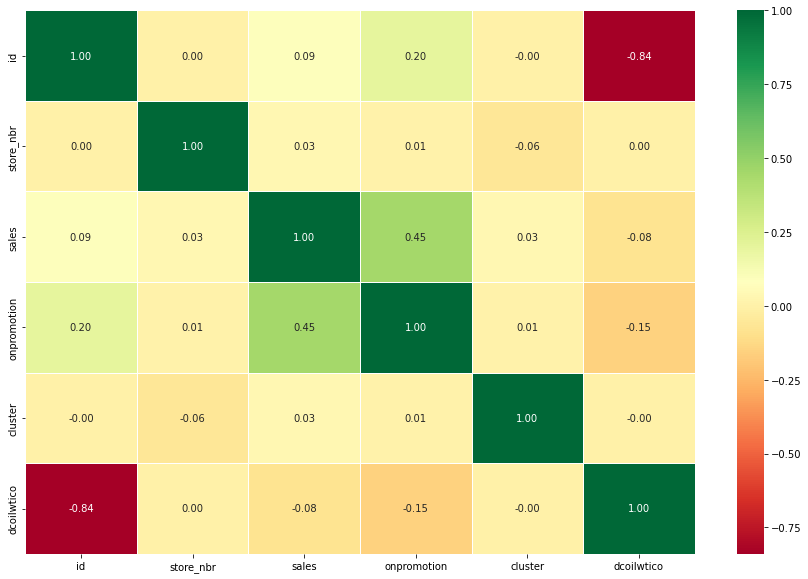

In [15]:
corr_matrix = df_eda.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="RdYlGn");

In [16]:
#change price to log2 for modeling
df_tmp['sales'] = df_tmp['sales'].replace(0,df_tmp['sales'].median())
df_tmp['sales'] = np.log2(df_tmp['sales'])

## Modeling

In [17]:
#since sklearn is out of date, create rmsle score, and add other metrics
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

In [18]:
#drop some fields
# df_tmp = df_tmp.drop(["cluster", "store_nbr", "saleDay", "saleDayOfWeek", "saleDayOfYear"], axis=1)

In [19]:
# Split data to train and validate
df_val = df_tmp[df_tmp.saleYear == 2017]
df_train = df_tmp[df_tmp.saleYear != 2017]

In [20]:
X_train, y_train = df_train.drop("sales", axis=1), df_train.sales
X_valid, y_valid = df_val.drop("sales", axis=1), df_val.sales

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1855062, 15), (1855062,), (288684, 15), (288684,))

In [21]:
model = GradientBoostingRegressor()

In [22]:
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [26]:
model.score(y_train, y_valid)

ValueError: Expected 2D array, got 1D array instead:
array=[ 3.321928  3.321928  3.321928 ...  2.807355  3.321928 12.803902].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.